## Counting Blood Cells Task Competition

### Neta Cohn
### Lior Trieman


#Excercise:

1) Read the data (process the outputs) and split it to train
and test

2) Prepare the labels

3) Define the network

4) Train the network

5) Infer prediction (count the cells)

## 1) Load and process the labels 
 split it to train and test

In [2]:
# imports
import numpy as np
import pandas as pd
import os
from PIL import Image
import copy
import time
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.optim import lr_scheduler

In [3]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [4]:
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
# Set the path to the folder containing the PNG images
folder_path = '/content/drive/MyDrive/DeepLearningHW/HW_6/data/labels'  # Neta
folder_path = 'drive/MyDrive/Y-data/HW_3_DL/cell-dataset/data/labels'  # Lior

# init the numpy arrays
label_value_list = [] # ini a list of count - the label
label_name_list = []  #init a list of label names/indeces

# Loop through each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        image = Image.open(os.path.join(folder_path, filename))
        # Convert the image to a NumPy array
        array = np.array(image)
        sum_arr = np.sum(array.flatten())  # number of red dots*255
        label_value_list.append(int(sum_arr/255))  # list of labels with values
        label_name_list.append(filename)            # list of labels "names"

In [7]:
# create a df for labels:
labels_df = pd.DataFrame({"label_ind":label_name_list, "label_val": label_value_list})

In [8]:
labels_df.head()

,label_ind,label_val
0,187dots.png,95
1,196dots.png,84
2,191dots.png,154
3,192dots.png,128
4,197dots.png,218


In [9]:
labels_df.describe()

,label_val
count,200.000000
mean,175.960000
std,61.398594
min,74.000000
25%,123.500000
50%,174.500000
75%,218.250000
max,317.000000


In [10]:
# sort the df by index 
labels_df = labels_df.sort_values('label_ind', ascending=True)

In [11]:
labels_df

,label_ind,label_val
193,001dots.png,135
194,002dots.png,233
195,003dots.png,82
188,004dots.png,86
196,005dots.png,96
...,...,...
1,196dots.png,84
4,197dots.png,218
6,198dots.png,79
20,199dots.png,153


In [12]:
# rename the label_ind name to fit image names and save a df with the image name and label
image_labels_df = labels_df.copy()
image_labels_df['label_ind'] = image_labels_df['label_ind'].str.replace('dots', 'cell')
image_labels_df.head()

,label_ind,label_val
193,001cell.png,135
194,002cell.png,233
195,003cell.png,82
188,004cell.png,86
196,005cell.png,96


Plot one image of label to see we understand our data:

In [13]:
# Convert the PIL Image to a NumPy array
array = np.array(image)

# Print the shape of the array
print(array.shape)

(256, 256, 3)


we can see that each label has a dim of  (256,256,3)
let's imshow it:

In [14]:
# image mode:
image.mode

'RGB'

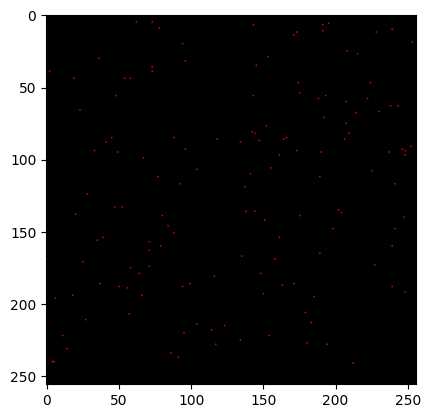

In [15]:
# Display the image using Matplotlib
plt.imshow(array)
plt.show()

In [16]:
# let's sum the values of each channel to make sure we have counts only in the red channel:
summed_arr = np.sum(array, axis=0)
sum = np.sum(summed_arr, axis=0)

In [17]:
sum

array([36465,     0,     0], dtype=uint64)

Indeed the values are only in the Red channel, BAM!

## 2) Loading the images with the cells (images)

In [18]:
# Set the path to the folder containing the PNG images
folder_path = '/content/drive/MyDrive/DeepLearningHW/HW_6/data/images' # Neta
folder_path = 'drive/MyDrive/Y-data/HW_3_DL/cell-dataset/data/images'  # Lior

# init the numpy arrays
images = [] # ini a list of count - the label
names = []  #init a list of label names/indeces

# Loop through each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        image = Image.open(os.path.join(folder_path, filename))
        images.append(image) # list of the images numpy array
        names.append(filename) # list of images "names"

In [19]:
print("Images shape:", len(images))
print("Img_Names shape:", len(names))

Images shape: 200
Img_Names shape: 200


In [20]:
# image mode:
image.mode

'RGB'

In [21]:
# let's sum the values of each channel to make sure we have counts only in the red channel:
array = np.array(image)
summed_arr = np.sum(array, axis=0)
sum = np.sum(summed_arr, axis=0)
sum

array([  28479,   32265, 4902634], dtype=uint64)

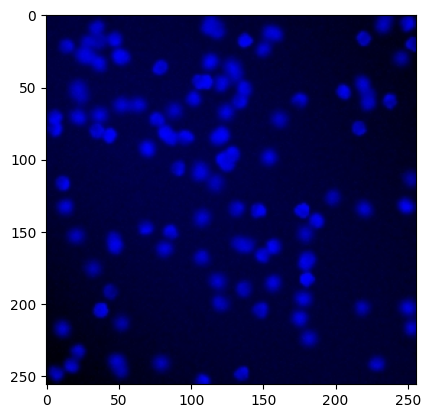

In [22]:
# Display the image using Matplotlib
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()

Dataset class: get the images and image name and fit it with the right labels (= cell count)

In [23]:
class CustomImageDataset(Dataset):

    def __init__(self, img_labels, img_dir, transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

Divide to train, val and test sets and preprocess the data to fit the cnn net

## 3) Creating Datasets, transform and process to fit the CNN

In [24]:
# img_dir = '/content/drive/MyDrive/DeepLearningHW/HW_6/data/images'  # Neta
img_dir = folder_path

# Define the transform:
transform = transforms.Compose([
    transforms.Resize(255),  # to fit the cnn
    transforms.ToTensor()
])

# Divide to train val test datasets:
train_set = CustomImageDataset(img_labels=image_labels_df[:-40], img_dir=img_dir, transform=transform)
val_set = CustomImageDataset(img_labels=image_labels_df[160:180], img_dir=img_dir, transform=transform)
test_set = CustomImageDataset(img_labels=image_labels_df[180:], img_dir=img_dir, transform=transform)

# sub sets size
dataset_sizes={'train': 0, 'val': 0, 'test': 0}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(val_set)
dataset_sizes['test'] = len(test_set)

In [25]:
dataset_sizes

{'train': 160, 'val': 20, 'test': 20}

## 4) Define a Data loader

## 4.1) Feel the data, hist plot the labels

In [26]:
train_labels = labels_df.label_val[:160]
val_labels = labels_df.label_val[160:180]
test_labels = labels_df.label_val[180:]

In [27]:
print(f"min label in train:{min(train_labels)} min label in val {min(val_labels)} min label in test {min(test_labels)}")
print(f"mean label in train:{np.mean(train_labels)} mean label in val {np.mean(val_labels)} mean label in test {np.mean(test_labels)}")
print(f"max label in train:{max(train_labels)} max label in val {max(val_labels)} max label in test {max(test_labels)}")

min label in train:74 min label in val 81 min label in test 79
mean label in train:178.7125 mean label in val 159.6 mean label in test 170.3
max label in train:317 max label in val 297 max label in test 292


Text(0.5, 1.0, 'train set')

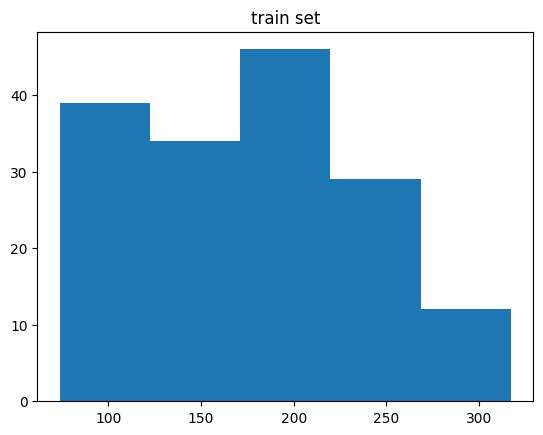

In [28]:
# plot training labels:
plt.hist(train_labels,bins=5)
plt.title('train set')

Text(0.5, 1.0, 'val set')

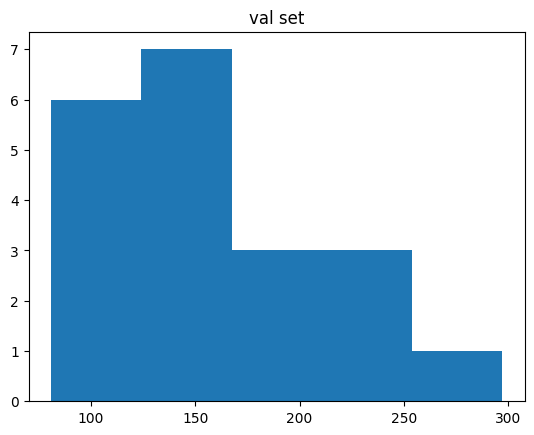

In [29]:
# plot val labels:
plt.hist(val_labels,bins=5)
plt.title('val set')

Text(0.5, 1.0, 'test set')

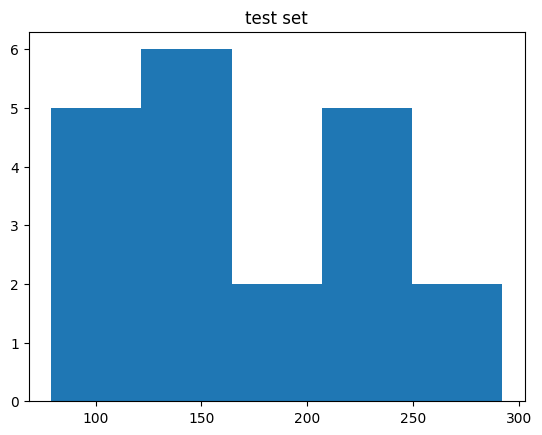

In [30]:
# plot test labels:
plt.hist(test_labels,bins=5)
plt.title('test set')

In [31]:
batch_size = 16 # hyper param
# batch_size = 8 # hyper param

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size,
                        shuffle=False, num_workers=0),
    'test': DataLoader(test_set, batch_size=20,
                        shuffle=False, num_workers=0)
  }

Sanity check the dataloader

In [32]:
train_features, train_labels = next(iter(dataloaders['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 255, 255])
Labels batch shape: torch.Size([16])


Label: 196


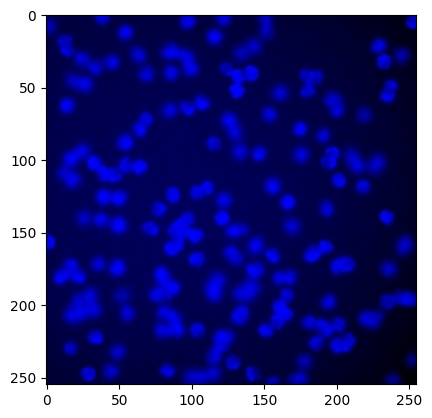

In [33]:
img = train_features[0].squeeze()  # remove dim of size 1 from the array
label = train_labels[0]
print(f"Label: {label}")
image = img.numpy()
image = np.transpose(image)
plt.imshow(image)
plt.show()

In [34]:
image.shape

(255, 255, 3)

(array([[153.,  87.,  14., ...,   0.,   0.,   0.],
        [135.,  90.,  27., ...,   0.,   0.,   0.],
        [142.,  92.,  18., ...,   0.,   0.,   0.],
        ...,
        [173.,  67.,  13., ...,   0.,   0.,   0.],
        [143.,  82.,  22., ...,   0.,   0.,   0.],
        [169.,  71.,  13., ...,   0.,   0.,   0.]]),
 array([0.        , 0.0027451 , 0.0054902 , 0.00823529, 0.01098039,
        0.01372549, 0.01647059, 0.01921569, 0.02196078, 0.02470588,
        0.02745098]),
 <a list of 255 BarContainer objects>)

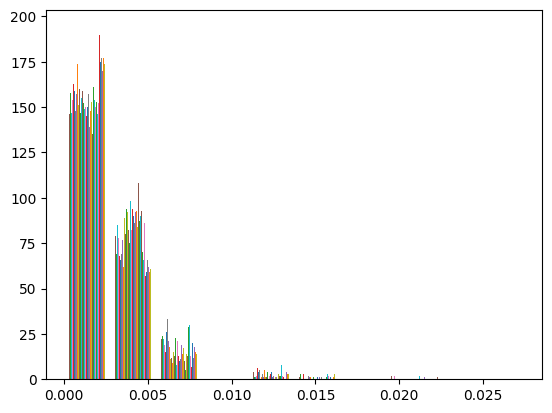

In [35]:
plt.hist(image[:,:,0])

(array([[167.,  67.,  18., ...,   0.,   0.,   0.],
        [148.,  80.,  21., ...,   0.,   0.,   0.],
        [151.,  87.,  15., ...,   0.,   0.,   0.],
        ...,
        [149.,  86.,  16., ...,   0.,   0.,   0.],
        [154.,  76.,  20., ...,   0.,   0.,   0.],
        [173.,  71.,   9., ...,   0.,   0.,   0.]]),
 array([0.        , 0.0027451 , 0.0054902 , 0.00823529, 0.01098039,
        0.01372549, 0.01647059, 0.01921569, 0.02196078, 0.02470588,
        0.02745098]),
 <a list of 255 BarContainer objects>)

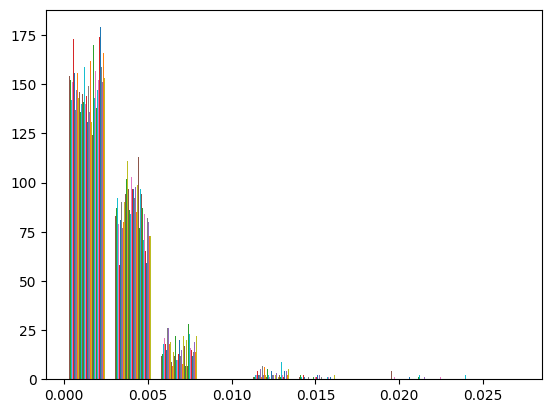

In [36]:
plt.hist(image[:,:,1])

(array([[  0.,   8., 141., ...,   2.,   6.,   0.],
        [  0.,   7., 143., ...,   1.,   7.,   0.],
        [  0.,   4., 151., ...,   2.,   1.,   6.],
        ...,
        [ 39., 169.,   8., ...,   6.,   3.,   0.],
        [ 40., 171.,  11., ...,   4.,   3.,   0.],
        [ 47., 168.,  15., ...,   7.,   0.,   0.]]),
 array([0.        , 0.09921569, 0.19843137, 0.29764706, 0.39686275,
        0.49607843, 0.59529412, 0.6945098 , 0.79372549, 0.89294118,
        0.99215686]),
 <a list of 255 BarContainer objects>)

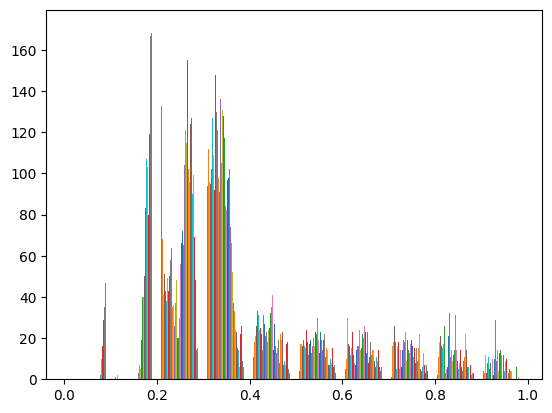

In [ ]:
plt.hist(image[:,:,2])

Define ploting functions

In [ ]:
def plot_convergence(dict_res, num_epochs):
  '''plot the loss vs. trainig epochs'''
  plt.figure()
  plt.plot( dict_res['train'][0],'*-'); plt.plot(dict_res['val'][0],'*-')
  plt.title('Loss')
  plt.legend(['train','val'])
  plt.figure()

In [ ]:
def plot_prediction(labels,outputs):
  '''plot the predicted vs. true counts'''
  plt.figure()
  plt.scatter(labels.detach().numpy(), outputs.detach().numpy())
  plt.title('Predicted Counts Vs. True Counts')
  plt.xlabel('True Counts')
  plt.ylabel('Predicted Counts')

# BEST MODEL SO FAR:

In [ ]:
import torch
import torch.nn as nn

class CellCountingCNN(nn.Module):
    def __init__(self):
        super(CellCountingCNN, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(64 * 31 * 31, 128)
        self.relu4 = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

In [ ]:
from torchsummary import summary
cnn = CellCountingCNN()
# If a GPU is available, make the model use it
mode1 = cnn.to(device)
summary(mode1,(3,255,255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 255, 255]             448
              ReLU-2         [-1, 16, 255, 255]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 127, 127]           4,640
              ReLU-5         [-1, 32, 127, 127]               0
         MaxPool2d-6           [-1, 32, 63, 63]               0
            Conv2d-7           [-1, 64, 63, 63]          18,496
              ReLU-8           [-1, 64, 63, 63]               0
         MaxPool2d-9           [-1, 64, 31, 31]               0
           Linear-10                  [-1, 128]       7,872,640
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 1]             129
Total params: 7,896,353
Trainable params: 7,896,353
Non-trainable params: 0
---------------------------

In [ ]:
def train_model_1(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. 

                    loss = criterion(outputs.squeeze(), labels.float())

                    # ==== backward pass ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][0,epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [ ]:
from torch.optim import lr_scheduler

cnn = CellCountingCNN()
# If a GPU is available, make the model use it
mode1 = cnn.to(device)
criterion = nn.L1Loss()  # MAE loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 50

In [ ]:
# train
model_1, dict_res = train_model_1(mode1, dataloaders, criterion, optimizer, num_epochs)

Epoch 0/49
----------
train Loss: 35051.6686
val Loss: 26961.7352

Epoch 1/49
----------
train Loss: 32698.6918
val Loss: 24074.5355

Epoch 2/49
----------
train Loss: 28164.4504
val Loss: 18738.5730

Epoch 3/49
----------
train Loss: 20214.9310
val Loss: 10395.0691

Epoch 4/49
----------
train Loss: 9360.7512
val Loss: 2294.0469

Epoch 5/49
----------
train Loss: 2297.2662
val Loss: 2812.0828

Epoch 6/49
----------
train Loss: 2321.8311
val Loss: 2059.7338

Epoch 7/49
----------
train Loss: 1664.5683
val Loss: 1281.1918

Epoch 8/49
----------
train Loss: 1617.0922
val Loss: 1318.8433

Epoch 9/49
----------
train Loss: 1474.9255
val Loss: 1390.8742

Epoch 10/49
----------
train Loss: 1432.1436
val Loss: 1374.7252

Epoch 11/49
----------
train Loss: 1386.6460
val Loss: 1231.9457

Epoch 12/49
----------
train Loss: 1360.1936
val Loss: 1288.2201

Epoch 13/49
----------
train Loss: 1293.0035
val Loss: 1189.5243

Epoch 14/49
----------
train Loss: 1249.0899
val Loss: 1158.4843

Epoch 15/49


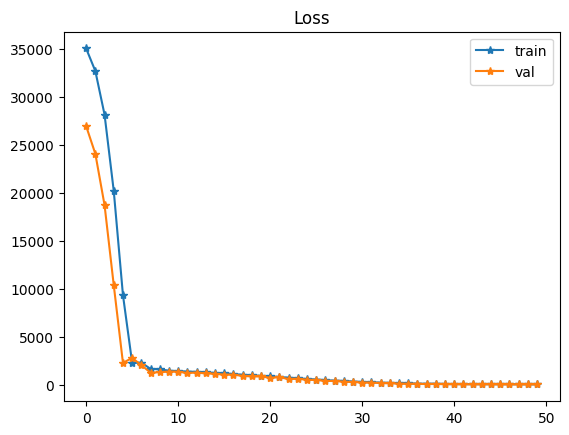

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_convergence(dict_res, num_epochs)

In [ ]:
for inputs, labels in dataloaders['test']:
  # Prepare the inputs for GPU/CPU
  inputs = inputs.to(device)
  labels = labels.to(device)

outputs = model_1(inputs) # apply the model to the inputs. 
outputs.detach().numpy()


array([[ 79.25673],
       [281.97488],
       [245.55673],
       [221.60587],
       [232.78662],
       [219.40305],
       [ 99.1914 ],
       [144.32462],
       [ 97.40625],
       [265.97192],
       [156.66196],
       [130.6844 ],
       [208.24852],
       [167.92479],
       [208.47018],
       [ 89.36466],
       [226.06642],
       [ 79.53124],
       [155.33484],
       [127.1916 ]], dtype=float32)

In [ ]:
true_counts = labels.detach().numpy()

In [ ]:
model_BEST_MAE = np.sum(np.abs(labels.detach().numpy() - outputs.squeeze().detach().numpy()))/len(labels.detach().numpy())
model_BEST_MAE

5.967888641357422

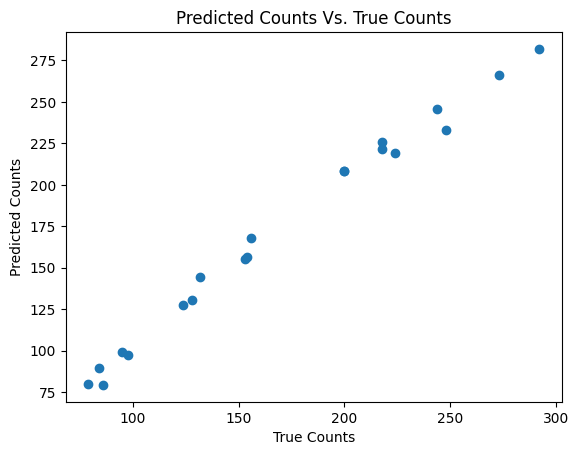

In [ ]:
plot_prediction(labels,outputs)

## 5) Model 1


In [ ]:
import torch
import torch.nn as nn

class CellCountingCNN_Bigger(nn.Module):
    def __init__(self):
        super(CellCountingCNN_Bigger, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 31 * 31, 256)
        self.relu4 = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

In [ ]:
from torchsummary import summary
cnn = CellCountingCNN_Bigger()
# If a GPU is available, make the model use it
mode1 = cnn.to(device)
summary(mode1,(3,255,255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 255, 255]             896
              ReLU-2         [-1, 32, 255, 255]               0
         MaxPool2d-3         [-1, 32, 127, 127]               0
            Conv2d-4         [-1, 64, 127, 127]          18,496
              ReLU-5         [-1, 64, 127, 127]               0
         MaxPool2d-6           [-1, 64, 63, 63]               0
            Conv2d-7          [-1, 128, 63, 63]          73,856
              ReLU-8          [-1, 128, 63, 63]               0
         MaxPool2d-9          [-1, 128, 31, 31]               0
           Linear-10                  [-1, 256]      31,490,304
             ReLU-11                  [-1, 256]               0
           Linear-12                    [-1, 1]             257
Total params: 31,583,809
Trainable params: 31,583,809
Non-trainable params: 0
-------------------------

### 5.1) Training the CNN

In [ ]:
def train_model_1(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. 

                    loss = criterion(outputs.squeeze(), labels.float())

                    # ==== backward pass ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][0,epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

### 5.2) Training models

In [ ]:
# init model:
cnn = CellCountingCNN_Bigger()
model1 = cnn.to(device)
# define criterions:
criterion = nn.L1Loss()  # MAE loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)
num_epochs = 50

In [ ]:
# train the model:
model_1, dict_res = train_model_1(model1, dataloaders, criterion, optimizer, num_epochs)

Epoch 0/49
----------
train Loss: 33798.7955
val Loss: 23666.7680

Epoch 1/49
----------
train Loss: 24206.4624
val Loss: 10764.6870

Epoch 2/49
----------
train Loss: 6431.9570
val Loss: 2684.3524

Epoch 3/49
----------
train Loss: 3425.6087
val Loss: 2247.0673

Epoch 4/49
----------
train Loss: 1815.5950
val Loss: 1387.4357

Epoch 5/49
----------
train Loss: 1763.5343
val Loss: 1500.1423

Epoch 6/49
----------
train Loss: 1594.6995
val Loss: 1560.5661

Epoch 7/49
----------
train Loss: 1453.7117
val Loss: 1245.6629

Epoch 8/49
----------
train Loss: 1441.4826
val Loss: 1216.1455

Epoch 9/49
----------
train Loss: 1328.5947
val Loss: 1303.3965

Epoch 10/49
----------
train Loss: 1218.8837
val Loss: 1010.4568

Epoch 11/49
----------
train Loss: 1119.8353
val Loss: 1027.6002

Epoch 12/49
----------
train Loss: 1009.8595
val Loss: 907.3541

Epoch 13/49
----------
train Loss: 965.9309
val Loss: 870.4563

Epoch 14/49
----------
train Loss: 834.9731
val Loss: 743.7313

Epoch 15/49
---------

### 5.3) Infering for test samples

In [ ]:
for inputs, labels in dataloaders['test']:
  # Prepare the inputs for GPU/CPU
  inputs = inputs.to(device)
  labels = labels.to(device)


In [ ]:
# outputs should be integers
outputs = model_1(inputs) # apply the model to the inputs. 
outputs.detach().numpy()
true_counts = labels.detach().numpy()

### 5.4) Calculated and Plot Results

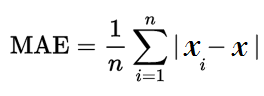

In [ ]:
## calculate MAE
model_1_MAE = np.sum(np.abs(labels.detach().numpy() - outputs.squeeze().detach().numpy()))/len(labels.detach().numpy())
model_1_MAE

5.502239990234375

Plot results

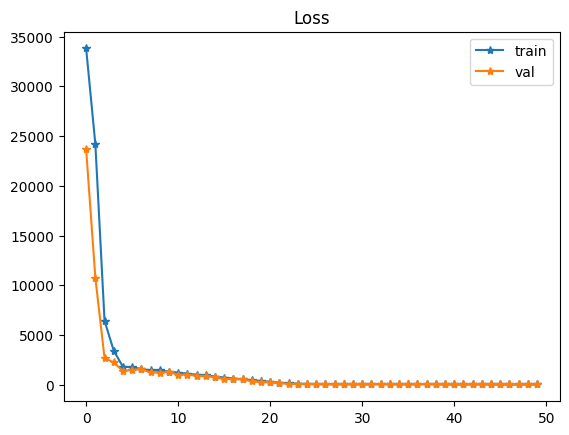

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_convergence(dict_res, num_epochs)

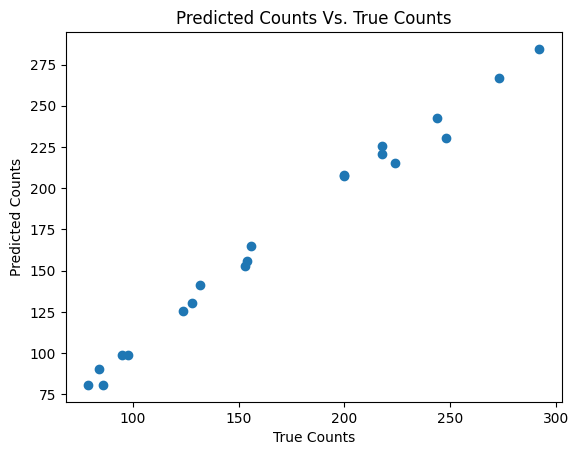

In [ ]:
plot_prediction(true_counts,outputs)

## 6) Model 2

the CNN

In [ ]:
import torch
import torch.nn as nn

class CellCountingCNN(nn.Module):
    def __init__(self):
        super(CellCountingCNN, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(64 * 31 * 31, 128)
        self.relu4 = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

In [ ]:
from torchsummary import summary
cnn = CellCountingCNN()
# If a GPU is available, make the model use it
mode1 = cnn.to(device)
summary(mode1,(3,255,255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 255, 255]             448
              ReLU-2         [-1, 16, 255, 255]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 127, 127]           4,640
              ReLU-5         [-1, 32, 127, 127]               0
         MaxPool2d-6           [-1, 32, 63, 63]               0
            Conv2d-7           [-1, 64, 63, 63]          18,496
              ReLU-8           [-1, 64, 63, 63]               0
         MaxPool2d-9           [-1, 64, 31, 31]               0
           Linear-10                  [-1, 128]       7,872,640
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 1]             129
Total params: 7,896,353
Trainable params: 7,896,353
Non-trainable params: 0
---------------------------

training function

In [ ]:
def train_model_2(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. 
                    loss = criterion(outputs.squeeze(), labels.float())

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][0,epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [ ]:
# init the model
cnn = CellCountingCNN()
model2 = cnn.to(device)
# define criterions:
criterion = nn.L1Loss()  # MAE loss
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 50

In [ ]:
# train the model
model_2, dict_res = train_model_2(model2, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/49
----------
train Loss: 178.4746
val Loss: 159.0267

Epoch 1/49
----------
train Loss: 176.7071
val Loss: 151.7101

Epoch 2/49
----------
train Loss: 146.5431
val Loss: 139.6533

Epoch 3/49
----------
train Loss: 109.6702
val Loss: 43.0489

Epoch 4/49
----------
train Loss: 63.7584
val Loss: 50.5356

Epoch 5/49
----------
train Loss: 50.2253
val Loss: 45.1946

Epoch 6/49
----------
train Loss: 68.8714
val Loss: 28.7667

Epoch 7/49
----------
train Loss: 30.3893
val Loss: 24.2578

Epoch 8/49
----------
train Loss: 35.9823
val Loss: 26.4996

Epoch 9/49
----------
train Loss: 39.2192
val Loss: 40.7588

Epoch 10/49
----------
train Loss: 30.8744
val Loss: 29.9549

Epoch 11/49
----------
train Loss: 22.3256
val Loss: 15.4278

Epoch 12/49
----------
train Loss: 16.4284
val Loss: 11.6499

Epoch 13/49
----------
train Loss: 11.7060
val Loss: 16.0268

Epoch 14/49
----------
train Loss: 10.7779
val Loss: 9.3387

Epoch 15/49
----------
train Loss: 8.1272
val Loss: 8.3214

Epoch 16/49
--

calculate and plot results

In [ ]:
# outputs should be integers
outputs = model_2(inputs) # apply the model to the inputs. 
outputs.detach().numpy()
true_counts = labels

In [ ]:
## calculate MAE
model_2_MAE = np.sum(np.abs(true_counts.detach().numpy() - outputs.squeeze().detach().numpy()))/len(true_counts.detach().numpy())
model_2_MAE

6.860534286499023

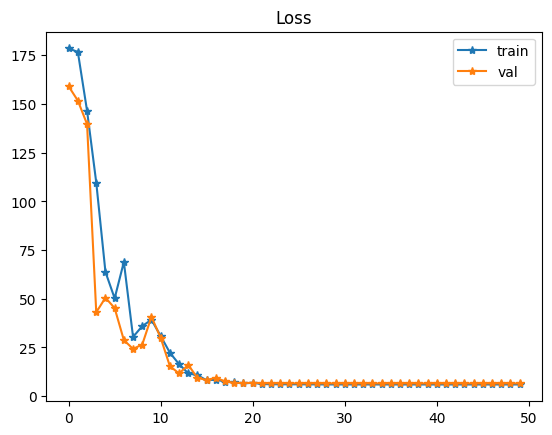

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_convergence(dict_res, num_epochs)

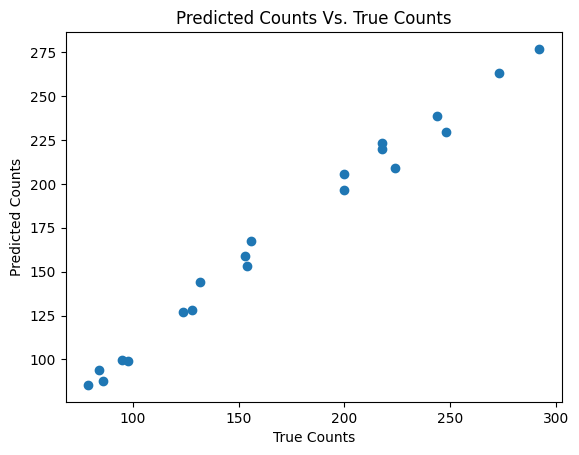

In [ ]:
plot_prediction(true_counts,outputs)

## 7) Model 3 - the bignet from model 1 with param of model 2:

In [ ]:
# init the model
cnn = CellCountingCNN_Bigger()
model3 = cnn.to(device)
# define criterions:
criterion = nn.L1Loss()  # MAE loss
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.0005, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 50

In [ ]:
# train the model
model_3, dict_res = train_model_2(model3, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/49
----------
train Loss: 178.2104
val Loss: 157.6877

Epoch 1/49
----------


KeyboardInterrupt: ignored

In [ ]:
# calculated and plot results

calculate and plot results

In [ ]:
# outputs should be integers
outputs = model_3(inputs) # apply the model to the inputs. 
outputs.detach().numpy()
true_counts = labels

In [ ]:
## calculate MAE
model_3_MAE = np.sum(np.abs(true_counts.detach().numpy() - outputs.squeeze().detach().numpy()))/len(true_counts.detach().numpy())
model_3_MAE

26.22709503173828

In [ ]:
plot_convergence(dict_res, num_epochs)

In [ ]:
plot_prediction(true_counts,outputs)

## 8) Data Augmentation and Running on the Big CNN


using the transform to perform data augmentation (and normalization)

In [ ]:
# img_dir = '/content/drive/MyDrive/DeepLearningHW/HW_6/data/images'  # Neta
img_dir = folder_path

# Define the transform:
transform = transforms.Compose([
    transforms.Resize(255),  # to fit the cnn
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Divide to train val test datasets:
train_set = CustomImageDataset(img_labels=image_labels_df[:-40], img_dir=img_dir, transform=transform)
val_set = CustomImageDataset(img_labels=image_labels_df[160:180], img_dir=img_dir, transform=transform)
test_set = CustomImageDataset(img_labels=image_labels_df[180:], img_dir=img_dir, transform=transform)

# sub sets size
dataset_sizes={'train': 0, 'val': 0, 'test': 0}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(val_set)
dataset_sizes['test'] = len(test_set)

In [ ]:
dataset_sizes

{'train': 160, 'val': 20, 'test': 20}

In [ ]:
batch_size = 16 # hyper param

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size,
                        shuffle=False, num_workers=0),
    'test': DataLoader(test_set, batch_size=20,
                        shuffle=False, num_workers=0)
  }

train

In [ ]:
# init the model
cnn = CellCountingCNN_Bigger()
model4 = cnn.to(device)
# define criterions:
criterion = nn.MSELoss()  # MAE loss
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)
# Decay LR by a factor of 0.1 every 7 epochs
num_epochs = 50

In [ ]:
# train the model

model_4, dict_res = train_model_1(model4, dataloaders, criterion, optimizer, num_epochs)

Epoch 0/49
----------
train Loss: 31508.1387
val Loss: 18034.7299

Epoch 1/49
----------
train Loss: 13639.9706
val Loss: 2735.7344

Epoch 2/49
----------
train Loss: 5009.8523
val Loss: 4564.4760

Epoch 3/49
----------
train Loss: 3311.6955
val Loss: 2374.1177

Epoch 4/49
----------
train Loss: 2943.7598
val Loss: 2460.7581

Epoch 5/49
----------
train Loss: 2559.2579
val Loss: 2048.9531

Epoch 6/49
----------
train Loss: 2091.5242
val Loss: 1525.3307

Epoch 7/49
----------
train Loss: 1608.1214
val Loss: 1210.4901

Epoch 8/49
----------
train Loss: 1120.3082
val Loss: 799.8287

Epoch 9/49
----------
train Loss: 785.4597
val Loss: 424.6093

Epoch 10/49
----------
train Loss: 515.0653
val Loss: 386.3084

Epoch 11/49
----------
train Loss: 237.9050
val Loss: 89.4331

Epoch 12/49
----------
train Loss: 110.2916
val Loss: 41.1638

Epoch 13/49
----------
train Loss: 66.5258
val Loss: 36.6976

Epoch 14/49
----------
train Loss: 63.9739
val Loss: 39.9090

Epoch 15/49
----------
train Loss: 6

In [ ]:
# outputs should be integers
outputs = model_4(inputs) # apply the model to the inputs. 
outputs.detach().numpy()
true_counts = labels

In [ ]:
## calculate MAE
model_4_MAE = np.sum(np.abs(true_counts.detach().numpy() - outputs.squeeze().detach().numpy()))/len(true_counts.detach().numpy())
model_4_MAE

26.22709503173828

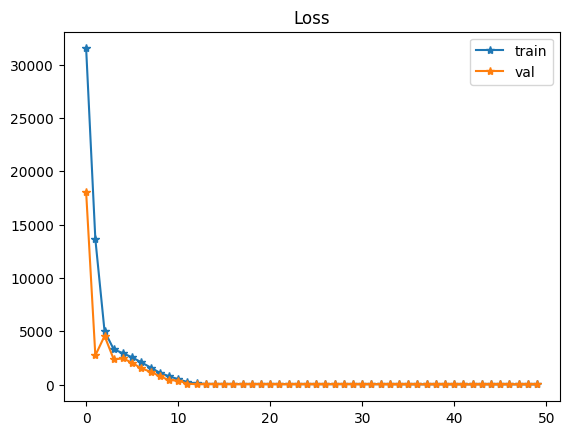

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_convergence(dict_res, num_epochs)

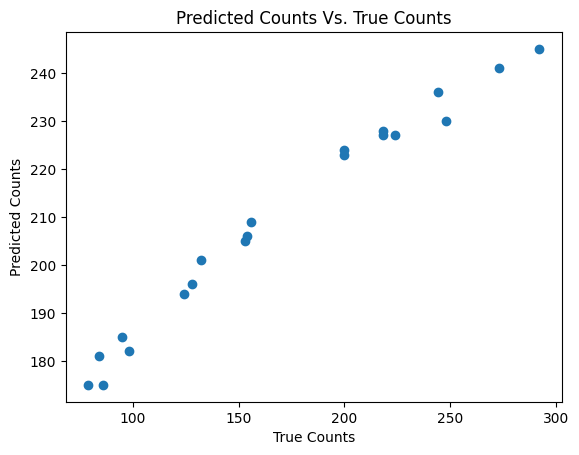

In [ ]:
plot_prediction(true_counts,outputs)

## 9) Updated train func where outputs are integers

In [ ]:
def train_model_5(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. 


                    loss = criterion(outputs.squeeze(), labels.float())

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][0,epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best loss Acc: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [ ]:
from torch.optim import lr_scheduler

cnn = CellCountingCNN()
# If a GPU is available, make the model use it
model5 = cnn.to(device)
criterion = nn.L1Loss()  # MAE loss
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 50

In [ ]:
model_5, dict_res = train_model_5(model5, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/49
----------
train Loss: 178.1620
val Loss: 156.7261

Epoch 1/49
----------
train Loss: 153.4149
val Loss: 159.5761

Epoch 2/49
----------
train Loss: 178.6208
val Loss: 159.4515

Epoch 3/49
----------
train Loss: 178.5053
val Loss: 159.3103

Epoch 4/49
----------
train Loss: 178.3282
val Loss: 159.0629

Epoch 5/49
----------
train Loss: 177.9030
val Loss: 158.2221

Epoch 6/49
----------
train Loss: 175.3568
val Loss: 149.9217

Epoch 7/49
----------
train Loss: 166.8362
val Loss: 143.7018

Epoch 8/49
----------
train Loss: 155.4557
val Loss: 122.4233

Epoch 9/49
----------
train Loss: 105.5648
val Loss: 47.2153

Epoch 10/49
----------
train Loss: 50.1911
val Loss: 43.7484

Epoch 11/49
----------
train Loss: 49.1665
val Loss: 52.1231

Epoch 12/49
----------
train Loss: 43.8510
val Loss: 36.1925

Epoch 13/49
----------
train Loss: 34.1288
val Loss: 23.0122

Epoch 14/49
----------
train Loss: 23.4610
val Loss: 23.7501

Epoch 15/49
----------
train Loss: 22.5295
val Loss: 20.9165


In [ ]:
# outputs should be integers
outputs = model_5(inputs) # apply the model to the inputs. 
outputs.detach().numpy()
true_counts = labels

In [ ]:
## calculate MAE
model_5_MAE = np.sum(np.abs(true_counts.detach().numpy() - outputs.squeeze().detach().numpy()))/len(true_counts.detach().numpy())
model_5_MAE

49.15

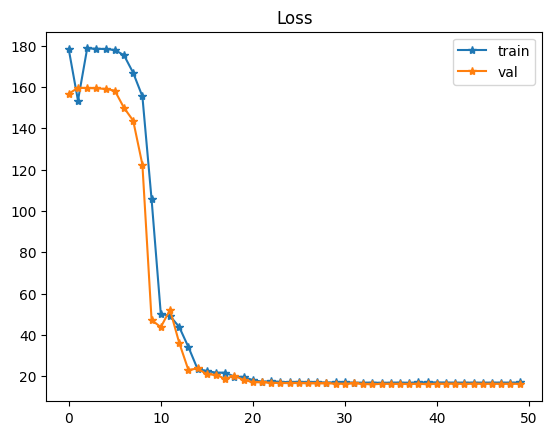

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_convergence(dict_res, num_epochs)

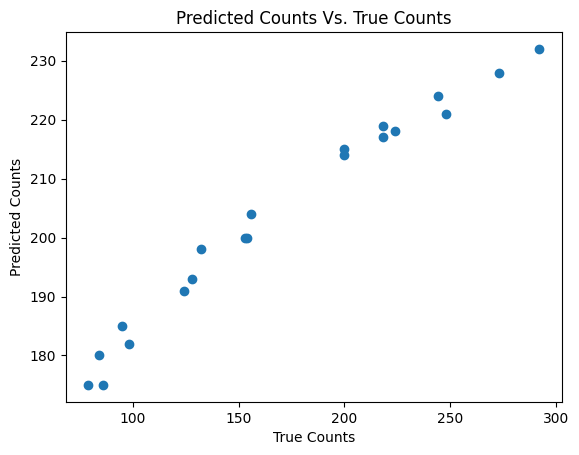

In [ ]:
plot_prediction(true_counts,outputs)

## 10) Summary

1. we calculated the true labels from images of binary values.
2. we loaded the labels and images into a dataloader. no special transformations
3. we divided the data to train (1:160) val(160:180) and test (180:200) sets
4. we created two cnns. one with 7milion param and the second with 30milion param.
5. we tried two learning methods: Adam and SGD with decay.
6. we tried data augmentation
7. we didn't try regularization, since we didn't see any overfitting during training process.
8. we didn't try trasnfer learning.
9. we tried 2 sizes of batch - 8/16



| Model  | Model 1 | Model 2 | Model 3 | Model 4 | Best Model |
|:--------:|:-------:|:--------:|:--------:|:--------:|:--------:|
| Param |  30mil   | 8mil | 30mil | 7mil |7mil |
| Epoch |  50   | 50 | 50 | 50 | 50 |
| criterion |  L2    | L1 | L1 |L1 |L2|
| optimaizer |  Adam   | SGD +scheduler | SGD +scheduler |Adam |Adam |
| batch size |  16   | 16 | 16 |16 + augmentation | 16|
| **MAE** | **6.55** | **6.8** | **22** | **26** | **5.5**|

In [ ]:
criterion = nn.L1Loss()  # MAE loss
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.0005, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 50